# 1. Import Required Libraries

In [1]:
%matplotlib inline

import torch
from torch import nn
import os
import gdal
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

import numpy as np
import mlflow
from lib.utils import *

# 2. Define Network Architecture

In [2]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 9 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(9, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 9, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))

        x = self.pool(x)
        # add second hidden layer
        #x = F.relu(self.conv2(x))
        #x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        #x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))
                
        return x

In [3]:
model = ConvAutoencoder()

In [4]:
def chunk_image(image):
    """
    Break a multispectral image into 9x4x4 tensors
    image: Pytorch tensor with dimensions CxHxW where in this application
        C is channels, H is height, and W is width
    returns:
        image: numpy array representing 
        ground_truth: 
    """
    data = []

    height = image[0].shape[0]
    width = image[0].shape[1]


    
    for i in range(0, height, 4):
        band_chunks = []

        if i + 3 > height - 1:
            break

        for j in range(0, width, 4):
            rows = []
            
            if j + 4 > width:
                break
                
            for band in image:
                chunk = np.ndarray(shape=(0))
                #try:
                half1 = np.append([band[i + 0][j:j + 4]], [band[i + 1][j:j + 4]], axis=0)
                half2 = np.append([band[i + 2][j:j + 4]], [band[i + 3][j:j + 4]], axis=0)
                #except:
                #print(height, width)
                #print(i, j)
                #break
                chunk = np.append(half1, half2, axis=0)

                rows.append(chunk)

            band_chunks.append(rows)

        data.append(band_chunks)
        
    data = np.array(data)
    return data

# 3. Load Satellite Data

In [5]:
data, filenames = load_data(10, "./data/modis")

In [6]:
labels = [data[i][0] for i in range(len(data))]
train_data = [data[i][1:] for i in range(len(data))]

In [7]:
from torch.utils.data import DataLoader

chunked_image = chunk_image(train_data[0])

trainloader = DataLoader(chunked_image, batch_size=500, shuffle=True)

# 4. Instantiate Model and Optimizer

In [8]:
model = ConvAutoencoder()

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
mlflow.set_tracking_uri("file:./mlruns")

In [11]:
print(mlflow.start_run())

<ActiveRun: info=<RunInfo: run_uuid='dbf90cbb21d6401b9a99b882566353d2', experiment_id=0, name='', source_type=4, source_name='C:\\Users\\rober\\Miniconda3\\envs\\crisis_mapping\\lib\\site-packages\\ipykernel_launcher.py', entry_point_name=None, user_id='unknown', status=1, start_time=1550789417773, end_time=None, source_version=None, lifecycle_stage='active', artifact_uri='./mlruns\\0\\dbf90cbb21d6401b9a99b882566353d2\\artifacts'>, data=None>


# 5. Define Loss Function

In [12]:
def criterion(ouput, expected):
    loss_function = nn.MSELoss()
    # Narrow fourth dimension, if uneven
    #if output.size(3) != expected.size(2):
    #    expected = torch.narrow(expected, 2, 1, output.size(3))
    # Narrow third dimension, if uneven
    #if output.size(2) != expected.size(1):
    #    expected = torch.narrow(expected, 1, 1, output.size(2))
    return loss_function(output, expected)

# 6. Move Model to GPU

In [13]:
use_cuda = False

if torch.cuda.is_available() and use_cuda:
    device = "cuda"
else:
    device = "cpu"

In [14]:
model.to(device)

ConvAutoencoder(
  (conv1): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 9, kernel_size=(2, 2), stride=(2, 2))
)

# 7. Train the Autoenconder

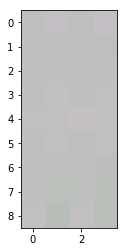

Epoch: 1 	Training Loss: 0.009787


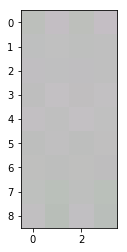

Epoch: 2 	Training Loss: 0.009726


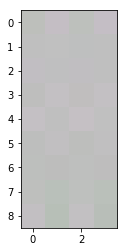

Epoch: 3 	Training Loss: 0.009664


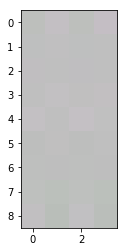

Epoch: 4 	Training Loss: 0.009601


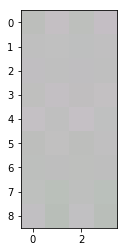

Epoch: 5 	Training Loss: 0.009535


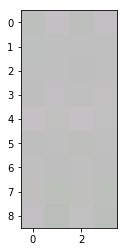

Epoch: 6 	Training Loss: 0.009467


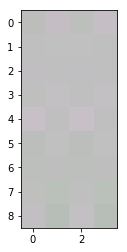

Epoch: 7 	Training Loss: 0.009397


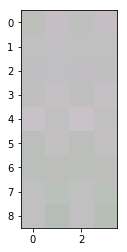

Epoch: 8 	Training Loss: 0.009324


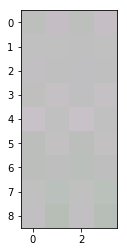

Epoch: 9 	Training Loss: 0.009248


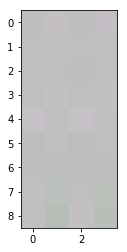

Epoch: 10 	Training Loss: 0.009169


In [15]:
epochs = 10

print_every = 16

for epoch in range(1, epochs + 1):
    train_loss = 0
    
    for index, batch in enumerate(trainloader):
        optimizer.zero_grad()
        # Convert data to tensor and send tensor to GPU, if available
        batch = batch.to(device)
        batch = batch.view(-1, 9, 4, 4)
        # torchvision.transforms.normalize(image, mean, std, inplace=False)
        # Forward pass
        output = model.forward(batch)
        # Calculate loss 
        loss = criterion(output, batch)
        train_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
        
        #if (index + 1) % print_every == 0:
    plt.imshow(output.squeeze().detach().numpy()[0])
    plt.show()
            #print(output.squeeze().detach().numpy().shape)
        
    avg_loss = train_loss/len(train_data)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        avg_loss
        ))

In [16]:
mlflow.end_run()

# 8. References
1. https://github.com/sjsu-earthquake-early-warning/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/Convolutional_Autoencoder_Solution.ipynb